In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm

# --- 1. Project Setup ---
# Assumes notebook is in 'notebooks/' folder
PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))

# Import Custom Modules
from src.evaluation.portfolio.signals import SignalFactory
from src.evaluation.portfolio.backtest import run_backtest, compute_decile_components
from src.evaluation.portfolio.performance import compute_metrics
from src.evaluation.portfolio.robustness import bootstrap_analysis
from src.evaluation.portfolio.attribution import (
    perform_factor_regression,
    get_attribution_summary,
)

# Styling
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
%matplotlib inline

In [2]:
# --- Configuration ---
RESULTS_PATH = PROJECT_ROOT / "data/processed/predictions/mat_walkforward.parquet"
RETURNS_PATH = PROJECT_ROOT / "data/processed/numerical_data/returns.parquet"
FACTORS_PATH = PROJECT_ROOT / "data/processed/numerical_data/factors_returns.parquet"
UNIVERSE_PATH = PROJECT_ROOT / "data/processed/numerical_data/sp500_universe.parquet"
COST_BPS = 0.0

print("⏳ Loading Datasets...")

# 1. Load Model Predictions
if not RESULTS_PATH.exists():
    raise FileNotFoundError(f"Missing predictions at {RESULTS_PATH}")
df_results = pd.read_parquet(RESULTS_PATH)
print(f"✅ Model Predictions: {df_results.shape}")

# 2. Load Simple Returns (Target)
if not RETURNS_PATH.exists():
    raise FileNotFoundError(f"Missing returns at {RETURNS_PATH}")

df_returns_raw = pd.read_parquet(RETURNS_PATH)
# Pivot to Matrix (Index=Date, Col=Permno)
# Assuming columns are ['date', 'permno', 'ret']
returns_matrix = df_returns_raw.pivot(
    index="date", columns="permno", values="return"
).fillna(0.0)
print(f"✅ Returns Matrix:    {returns_matrix.shape}")

# 3. Load Factors (MKT, SMB, HML, UMD, QMJ, BAB)
if not FACTORS_PATH.exists():
    raise FileNotFoundError(f"Missing factors at {FACTORS_PATH}")

df_factors = pd.read_parquet(FACTORS_PATH)
if "date" in df_factors.columns:
    df_factors = df_factors.set_index("date")

# Ensure Date alignment with returns (convert to datetime if needed)
df_factors.index = pd.to_datetime(df_factors.index)
print(f"✅ Factor Data:       {df_factors.shape} {list(df_factors.columns)}")

# 4. Load S&P 500 Universe Mask
if not UNIVERSE_PATH.exists():
    raise FileNotFoundError(f"Missing universe file at {UNIVERSE_PATH}")

df_universe = pd.read_parquet(UNIVERSE_PATH)
print(f"✅ Universe Mask:     {df_universe.shape}")

# Ensure Index is datetime
if not pd.api.types.is_datetime64_any_dtype(df_universe.index):
    df_universe.index = pd.to_datetime(df_universe.index)

⏳ Loading Datasets...
✅ Model Predictions: (13022890, 6)
✅ Returns Matrix:    (4530, 936)
✅ Factor Data:       (4026, 6) ['MKT', 'SMB', 'HML', 'UMD', 'QMJ', 'BAB']
✅ Universe Mask:     (4026, 1069)


In [3]:
print("⚙️ Generating Signal Strategies...")
factory = SignalFactory(df_results)
strategies = factory.get_all_signals()

print(f"Generated {len(strategies)} strategies:")
for name in strategies.keys():
    print(f" - {name}")

⚙️ Generating Signal Strategies...
   [SignalFactory] Pivoting raw predictions into multi-horizon tensor...
   [SignalFactory] Building Strategy: h1_only
   [SignalFactory] Building Strategy: h1_h5_mean
   [SignalFactory] Building Strategy: h1_h10_mean
   [SignalFactory] Building Strategy: smart_decay
   [SignalFactory] Building Strategy: conviction
Generated 5 strategies:
 - h1_only
 - h1_h5_mean
 - h1_h10_mean
 - smart_decay
 - conviction


In [15]:
all_metrics = []
equity_curves = pd.DataFrame()

print(f"🚀 Running Backtests (Cost = {COST_BPS} bps)...")

for name, signal_matrix in tqdm(strategies.items()):
    # 1. Run Backtest with Universe Mask
    bt_res = run_backtest(
        signal=signal_matrix,
        returns=returns_matrix,
        direction=1,
        factor_name=name,
        cost_bps=COST_BPS,
        universe_mask=df_universe,
        long_exposure=1,
        short_exposure=1,
        ema_span=1,  # Smoothed entry/exit over 3 days
    )

    # 2. Store Equity Curve
    net_ret = bt_res["net_returns"]
    turnover = bt_res["turnover"]
    equity_curves[name] = (1 + net_ret).cumprod()

    # 3. Compute Standard Metrics
    stats = compute_metrics(net_ret, turnover=turnover)
    stats["Strategy"] = name

    # 4. Attribution (Alpha/Beta)
    try:
        model = perform_factor_regression(net_ret, df_factors)
        attr = get_attribution_summary(model)

        # Extract Alpha
        stats["Alpha_Ann"] = (
            attr.loc["Alpha", "Ann. Alpha"] if "Alpha" in attr.index else np.nan
        )

        # Extract Betas
        for factor in df_factors.columns:
            stats[f"Beta_{factor}"] = (
                attr.loc[factor, "Beta"] if factor in attr.index else 0.0
            )

    except Exception as e:
        # FIX: Use np.nan instead of "Err" so styling doesn't crash
        stats["Alpha_Ann"] = np.nan
        print(f"⚠️ Attribution failed for {name}: {e}")

    all_metrics.append(stats)

print("Done.")

🚀 Running Backtests (Cost = 0.0 bps)...


  0%|          | 0/5 [00:00<?, ?it/s]

/Users/audricsicard/Documents/VSCode/AML Project/Modality-aware-transformer/src/evaluation/portfolio/backtest.py:109: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects.
  daily_turnover = (weights - drifted_weights).abs().sum(axis=1) / 2.0
/Users/audricsicard/Documents/VSCode/AML Project/Modality-aware-transformer/src/evaluation/portfolio/backtest.py:109: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects.
  daily_turnover = (weights - drifted_weights).abs().sum(axis=1) / 2.0
/Users/audricsicard/Documents/VSCode/AML Project/Modality-aware-transformer/src/evaluation/portfolio/backtest.py:109: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects.
  daily_turnover = (weights - drifted_weights).abs().sum(axis=1) / 2.0
/Users/audricsicard/Documents/VSCode/AML Project/

Done.


/Users/audricsicard/Documents/VSCode/AML Project/Modality-aware-transformer/src/evaluation/portfolio/backtest.py:109: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects.
  daily_turnover = (weights - drifted_weights).abs().sum(axis=1) / 2.0


In [16]:
# Create DataFrame
df_report = pd.DataFrame(all_metrics).set_index("Strategy")
df_report = df_report.sort_values("Sharpe Ratio", ascending=False)

# Columns to display
# Dynamic list of betas based on what was found in factors
beta_cols = [c for c in df_report.columns if c.startswith("Beta_")]
display_cols = [
    "Sharpe Ratio",
    "Annualized Return",
    "Annualized Vol",
    "Max Drawdown",
    "Alpha_Ann",
] + beta_cols

# Styling
styled_report = (
    df_report[display_cols]
    .style.background_gradient(subset=["Sharpe Ratio", "Alpha_Ann"], cmap="RdYlGn")
    .format(
        {
            "Sharpe Ratio": "{:.2f}",
            "Annualized Return": "{:.2%}",
            "Annualized Vol": "{:.2%}",
            "Max Drawdown": "{:.2%}",
            **{c: "{:.2f}" for c in beta_cols},  # Format all betas to 2 decimals
        }
    )
)

display(styled_report)

,Sharpe Ratio,Annualized Return,Annualized Vol,Max Drawdown,Alpha_Ann,Beta_MKT,Beta_SMB,Beta_HML,Beta_UMD,Beta_QMJ,Beta_BAB
Strategy,,,,,,,,,,,
conviction,0.54,10.73%,19.94%,-38.10%,0.098214,0.19,0.69,0.07,0.31,0.32,0.33
h1_only,0.52,10.36%,19.93%,-40.75%,0.092835,0.22,0.56,0.10,0.29,0.29,0.36
smart_decay,0.30,6.13%,20.35%,-35.58%,0.057095,0.17,0.72,0.12,0.41,0.40,0.32
h1_h5_mean,0.26,5.23%,20.34%,-36.08%,0.050021,0.16,0.72,0.12,0.42,0.40,0.32
h1_h10_mean,0.17,3.44%,20.48%,-38.18%,0.034462,0.14,0.79,0.12,0.45,0.42,0.32


In [10]:
# Create DataFrame
df_report = pd.DataFrame(all_metrics).set_index("Strategy")
df_report = df_report.sort_values("Sharpe Ratio", ascending=False)

# Columns to display
# Dynamic list of betas based on what was found in factors
beta_cols = [c for c in df_report.columns if c.startswith("Beta_")]
display_cols = [
    "Sharpe Ratio",
    "Annualized Return",
    "Annualized Vol",
    "Max Drawdown",
    "Alpha_Ann",
] + beta_cols

# Styling
styled_report = (
    df_report[display_cols]
    .style.background_gradient(subset=["Sharpe Ratio", "Alpha_Ann"], cmap="RdYlGn")
    .format(
        {
            "Sharpe Ratio": "{:.2f}",
            "Annualized Return": "{:.2%}",
            "Annualized Vol": "{:.2%}",
            "Max Drawdown": "{:.2%}",
            **{c: "{:.2f}" for c in beta_cols},  # Format all betas to 2 decimals
        }
    )
)

display(styled_report)

,Sharpe Ratio,Annualized Return,Annualized Vol,Max Drawdown,Alpha_Ann,Beta_MKT,Beta_SMB,Beta_HML,Beta_UMD,Beta_QMJ,Beta_BAB
Strategy,,,,,,,,,,,
conviction,0.86,22.35%,26.08%,-54.58%,0.097566,1.18,0.63,-0.11,0.23,-0.44,0.75
h1_only,0.83,21.71%,26.18%,-53.76%,0.089277,1.21,0.45,-0.06,0.22,-0.48,0.80
smart_decay,0.74,19.20%,25.80%,-52.87%,0.068512,1.16,0.62,-0.12,0.27,-0.43,0.74
h1_h5_mean,0.73,18.60%,25.60%,-51.72%,0.063804,1.15,0.62,-0.15,0.26,-0.44,0.74
h1_h10_mean,0.67,17.13%,25.44%,-51.83%,0.050705,1.13,0.65,-0.15,0.27,-0.43,0.72


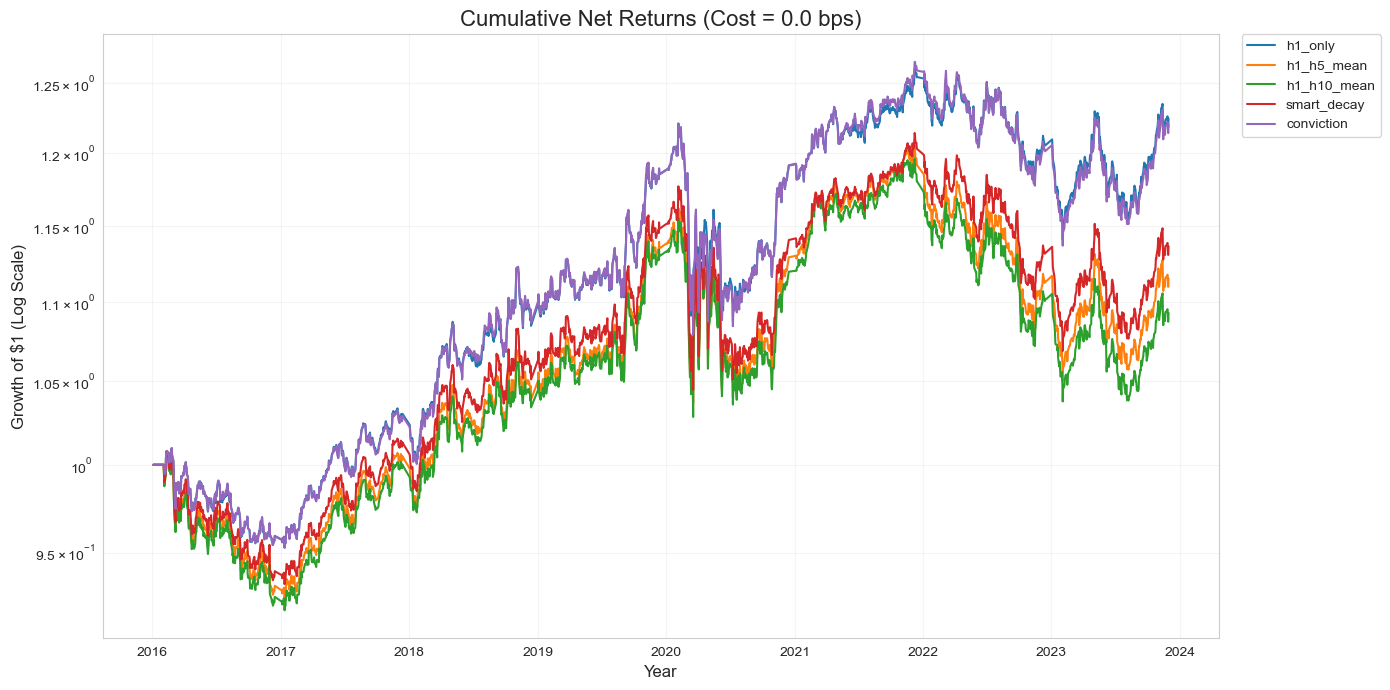

In [6]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=equity_curves, dashes=False, linewidth=1.5)

plt.title(f"Cumulative Net Returns (Cost = {COST_BPS} bps)", fontsize=16)
plt.ylabel("Growth of $1 (Log Scale)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.yscale("log")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.tight_layout()
plt.show()

In [7]:
# Identify Best Strategy
best_strategy = df_report.index[0]
print(f"\n🎲 Running Bootstrap Analysis for Winner: {best_strategy}...")

# Get returns
best_net_returns = equity_curves[best_strategy].pct_change().fillna(0.0)

# Run Bootstrap (1000 samples, ~1 month block size)
boot_res = bootstrap_analysis(best_net_returns, n_samples=1000, block_size=22)

display(boot_res)


🎲 Running Bootstrap Analysis for Winner: h1_only...


,5%,50%,95%,std
Annualized Return,-0.005309,0.028028,0.062178,0.020825
Annualized Vol,0.057248,0.065373,0.075439,0.005602
Sharpe Ratio,-0.077297,0.424755,0.983225,0.326045
Sortino Ratio,-0.104106,0.607248,1.458886,0.484990
Max Drawdown,-0.224357,-0.127934,-0.072434,0.047182
Calmar Ratio,-0.026136,0.212916,0.778058,0.252786
Skewness,-0.278156,0.187361,0.658953,0.284965
Kurtosis,1.925880,7.244377,10.629020,2.630585
Tail Ratio,0.955381,1.048900,1.145438,0.059154
Win Rate,0.486684,0.506527,0.524830,0.011601


In [8]:
def analyze_long_short(signal, returns, use_deciles=True, universe_mask=None):
    """
    Runs the backtest but returns Long and Short legs separately.
    Cost is set to 0.0 to see pure signal quality.
    """
    # 1. Get Weights
    weights = compute_decile_weights(signal, universe_mask=universe_mask)

    # 2. Split Weights
    long_weights = weights.where(weights > 0, 0.0)
    short_weights = weights.where(weights < 0, 0.0)

    # 3. Calculate Returns (No Cost)
    # Shift weights 1 day
    long_ret = (long_weights.shift(1) * returns).sum(axis=1)
    short_ret = (short_weights.shift(1) * returns).sum(axis=1)

    return long_ret, short_ret


# Run Autopsy on H1_Only
print("🕵️ Running Autopsy on H1 Strategy...")
long_leg, short_leg = analyze_long_short(
    strategies["h1_only"], returns_matrix, universe_mask=df_universe
)

# Plot
plt.figure(figsize=(12, 6))
(1 + long_leg).cumprod().plot(label="Long Leg Only (Buy Top 10%)", color="green")
(1 + short_leg).cumprod().plot(label="Short Leg Only (Sell Bot 10%)", color="red")
(1 + (long_leg + short_leg)).cumprod().plot(
    label="Combined (Dollar Neutral)", color="black", linewidth=2
)
plt.title("Autopsy: Long vs Short Performance (0 Costs)")
plt.legend()
plt.yscale("log")
plt.show()

print(f"Long Leg Ann. Return: {long_leg.mean() * 252:.2%}")
print(f"Short Leg Ann. Return: {short_leg.mean() * 252:.2%}")

🕵️ Running Autopsy on H1 Strategy...


TypeError: compute_decile_weights() missing 1 required positional argument: 'returns'

📊 Computing Quintile Returns (N=5)...


/Users/audricsicard/Documents/VSCode/AML Project/Modality-aware-transformer/src/evaluation/portfolio/quantile_analysis.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=ann_ret.index, y=ann_ret.values, palette=colors)


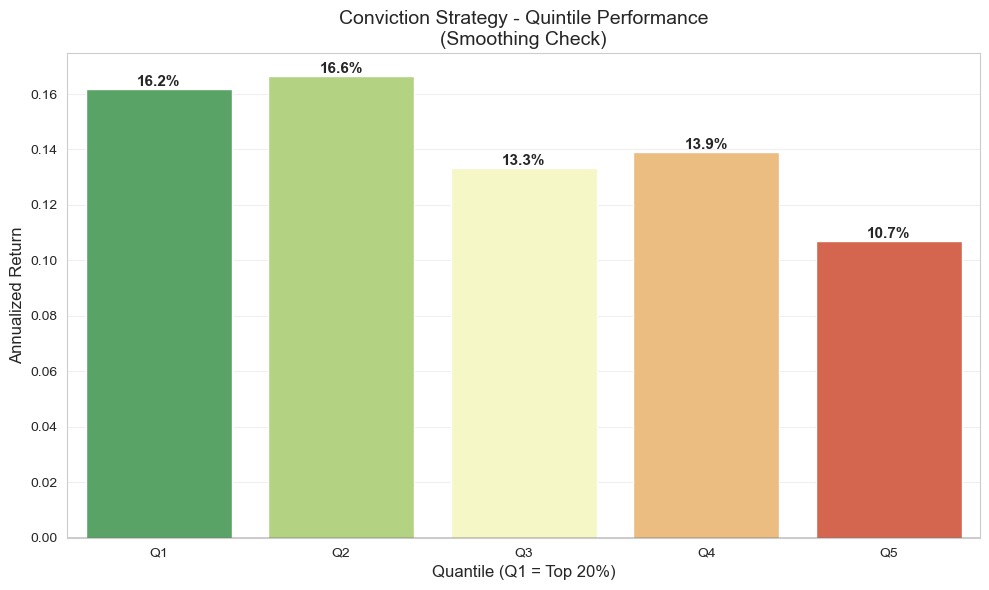

✅ Top-Bottom Spread (Q1 - Q5): 5.47%


In [4]:
from src.evaluation.portfolio.quantile_analysis import (
    compute_quantile_returns,
    plot_quantile_analysis,
)

# Use Conviction Strategy
target_signal = strategies["conviction"]

print("📊 Computing Quintile Returns (N=5)...")
df_quintiles = compute_quantile_returns(
    target_signal,
    returns_matrix,
    universe_mask=df_universe,
    n_bins=5,  # <--- QUINTILES
)

plot_quantile_analysis(df_quintiles, title="Conviction Strategy - Quintile Performance")